In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit,StratifiedKFold
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.externals import joblib
from datetime import datetime, date

import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
user_info = pd.read_csv('../data/data_format1/user_info_format1.csv')
user_log = pd.read_csv('../data/data_format1/user_log_format1.csv')

user_info.head()

,user_id,age_range,gender
0,376517,6.0,1.0
1,234512,5.0,0.0
2,344532,5.0,0.0
3,186135,5.0,0.0
4,30230,5.0,0.0


In [3]:
train_data = pd.read_csv('../data/data_format1/train_format1.csv')
test_data = pd.read_csv('../data/data_format1/test_format1.csv')

**观察下是数据**

In [36]:
user_info['user_id'].unique().shape

(424170,)

In [40]:
#缺省性别的用户
user_info[user_info['gender'].isna() | (user_info['gender'] == 2)].count()

user_id      16862
age_range    14664
gender       10426
dtype: int64

In [44]:
#缺省年龄的用户
user_info[user_info['age_range'].isna() | (user_info['age_range'] == 0)].count()

user_id      95131
age_range    92914
gender       90664
dtype: int64

In [46]:
user_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54925330 entries, 0 to 54925329
Data columns (total 7 columns):
user_id        int64
item_id        int64
cat_id         int64
seller_id      int64
brand_id       float64
time_stamp     int64
action_type    int64
dtypes: float64(1), int64(6)
memory usage: 2.9 GB


In [49]:
#用户行为覆盖所有的用户id
user_log['user_id'].unique().shape

(424170,)

In [51]:
user_log['seller_id'].unique().shape

(4995,)

In [12]:
train_data['merchant_id'].unique().shape

(1993,)

In [57]:
#训练集seller_id也是都在用户相关的seller中
len(list(set(train_data['merchant_id'].unique()).intersection(set(user_log['seller_id'].unique()))))

1993

**处理下缺失值**  
暂时不知怎么处理,年龄缺失挺多的,不知道怎么填充,暂时把性别处理一下

In [4]:
user_info[user_info['age_range'].isna() | (user_info['age_range'] == 0)].count()

#填为0
user_info['gender'].fillna(2, inplace=True)
user_info['age_range'].fillna(0, inplace=True)

In [13]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260864 entries, 0 to 260863
Data columns (total 3 columns):
user_id        260864 non-null int64
merchant_id    260864 non-null int64
label          260864 non-null int64
dtypes: int64(3)
memory usage: 6.0 MB


**观察和统计数据**

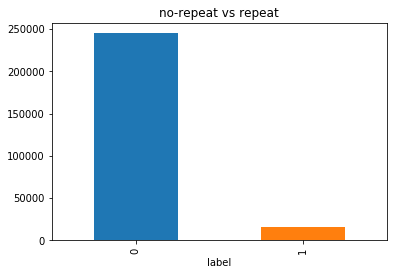

In [5]:
label_gp = train_data.groupby('label')['user_id'].count()
label_gp.plot(kind='bar',title='no-repeat vs repeat')

重复购买和不购买的,非常不均衡噢

In [8]:
user_log.groupby('user_id').size()

63

**合并训练集和测试集,方便抽取特征**

In [5]:
test_data['source'] = 'test'
train_data['source'] = 'train'

commit_data = test_data.drop(['prob'], axis=1)

data_combine = pd.concat([train_data,commit_data], sort=True)

data_combine = pd.merge(data_combine, user_info, how='left', on=['user_id'])
data_combine.head()

,label,merchant_id,source,user_id,age_range,gender
0,0.0,3906,train,34176,6.0,0.0
1,0.0,121,train,34176,6.0,0.0
2,1.0,4356,train,34176,6.0,0.0
3,0.0,2217,train,34176,6.0,0.0
4,0.0,4818,train,230784,0.0,0.0


In [110]:
data_combine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 522341 entries, 0 to 522340
Data columns (total 6 columns):
label          260864 non-null float64
merchant_id    522341 non-null int64
source         522341 non-null object
user_id        522341 non-null int64
age_range      522341 non-null float64
gender         522341 non-null float64
dtypes: float64(3), int64(2), object(1)
memory usage: 27.9+ MB


**抽取特征,添加一些新特征**

In [ ]:

def extract_features(user_id, seller_id):
    ret_user_data = pd.DataFrame()

    user_detail = user_log.loc[user_log.user_id == user_id, :]

    user_seller_data = {'user_id':[user_id], 'seller_id':[seller_id]}

    user_act_seller = user_detail[user_detail['seller_id'] == seller_id]
    
    view_action_count = len(user_act_seller)

    #卖家被浏览的次数
    user_seller_data['user_viewed_action_count'] = [view_action_count]

    #浏览物品种类数
    user_seller_data['user_viewed_item_cat_num'] = [len(user_detail['cat_id'].unique())]

    #浏览品牌种类数
    user_seller_data['user_viewed_item_brand_num'] = [len(user_detail['brand_id'].unique())]

    #用户各种操作
    action_count = dict(user_act_seller['action_type'].value_counts())
    user_seller_data['user_viewed_item_click'] = [action_count[0] if 0 in action_count else 0]
    user_seller_data['user_viewed_item_addcart'] = [action_count[1] if 1 in action_count else 0]
    user_seller_data['user_viewed_item_buy'] = [action_count[2] if 2 in action_count else 0]
    user_seller_data['user_viewed_item_addcat'] = [action_count[3] if 3 in action_count else 0]
    
    #加入购物车几率
    user_seller_data['user_addcart_ratio'] = [user_seller_data['user_viewed_item_addcart'][0] / view_action_count]
    
    #点击率
    user_seller_data['user_click_ratio'] = [user_seller_data['user_viewed_item_click'][0] / view_action_count]
    
    #购买率
    user_seller_data['user_buy_ratio'] = [user_seller_data['user_viewed_item_buy'][0] / view_action_count]
    
    #收藏率
    user_seller_data['user_addcat_ratio'] = [user_seller_data['user_viewed_item_addcat'][0] / view_action_count]
    
    #同个商品不同时间浏览次数大于1
    repeat_viewed_count = user_detail.groupby('item_id').apply(lambda x: len(x['time_stamp'].value_counts())>1).sum()
    user_seller_data['repeat_viewed_count'] = [repeat_viewed_count]
    
    #...再加一些统计特征

    #前面用[]形式,再实例化df,这样比直接给df赋值要快
    ret_user_data = pd.DataFrame(data=user_seller_data)
    
    return ret_user_data


#extract_features(100, 1)


#抽取特征
user_feature = pd.DataFrame()
start_time = datetime.now()

for i, item in enumerate(data_combine.loc[:,('user_id', 'merchant_id')].values):
    user_id = item[0]
    seller_id = item[1]
    tmp_list = []
    try:
        tmp_list.append(extract_features(user_id, seller_id))
        if i%1000 == 0:
            user_feature = pd.concat(tmp_list, ignore_index=True)
            tmp_list = []
            print(datetime.now()-start_time,i)
    except:
        print('====='*10)
        print('Error at id', user_id)

user_feature.to_csv('user_feature_1.csv', index=False)

#将所有seller_id one-hot
seller_unique = user_feature['seller_id'].unique()
for seller_id in seller_unique:
    user_feature['seller_'+str(seller_id)] = 1 * (user_feature['seller_id'] == seller_id)
    
user_feature.to_csv('user_feature_2.csv', index=False)
user_feature.head()

0:00:00.299017 0
0:02:29.623558 1000


In [11]:
start_time = datetime.now()
a = user_log[user_log.user_id == 100]
print(datetime.now()-start_time)

start_time = datetime.now()
a = user_log.loc[user_log.user_id == 100]
print(datetime.now()-start_time)

print(a.head())

start_time = datetime.now()
a[a['seller_id'] == 933]
print(datetime.now()-start_time)



0:00:00.103006
0:00:00.085005
         user_id  item_id  cat_id  seller_id  brand_id  time_stamp  \
5644270      100   636915     737        933     983.0        1008   
5644271      100  1008023     629          1    1662.0        1008   
5644272      100   564669    1252       1860     918.0        1008   
5644273      100  1008023     629          1    1662.0        1008   
5644274      100   918789     629          1    1662.0        1008   

         action_type  
5644270            0  
5644271            0  
5644272            0  
5644273            0  
5644274            0  
0:00:00.001000


In [44]:
ret_user_data = pd.DataFrame(data={'user_id':[1]})
ret_user_data

,user_id
0,1


In [152]:
sub = user_log.iloc[650:660,:]
#print(sub.groupby(['user_id','seller_id']).size())
a = sub.groupby(['user_id']).count()
a
# b = a.reset_index()
# b





,item_id,cat_id,seller_id,brand_id,time_stamp,action_type
user_id,,,,,,
139859,2,2,2,2,2,2
272389,8,8,8,8,8,8


In [10]:


start_time = datetime.now()
user_detail = user_log.loc[user_log.user_id == 100, :]
user_act_seller = user_detail[user_detail['seller_id'] == 1]
print((datetime.now()-start_time)*1000)

start_time = datetime.now()
user_detail = user_log.loc[(user_log.user_id == 100)&(user_log.seller_id==1), :]

print((datetime.now()-start_time)*1000)

0:01:51.006000
0:05:10.018000


In [124]:
d = pd.DataFrame(data={'user_id':[1],'seller_id':[2]})
print(d)
s = pd.Series({'user_id':3, 'seller_id':4})
pd.concat([d,s], ignore_index=True)


   user_id  seller_id
0        1          2


C:\Users\zzf\Anaconda3\lib\site-packages\pandas\core\indexes\api.py:107: RuntimeWarning: '<' not supported between instances of 'str' and 'int', sort order is undefined for incomparable objects
  result = result.union(other)


,user_id,seller_id
0,1,2


In [28]:
a = user_log.loc[(user_log['user_id']==34176)&(user_log['seller_id']==3906)]
print(a[a['item_id']==757713])

a.groupby('item_id').apply(lambda x: len(x['time_stamp'].value_counts()) > 1).sum()

          user_id  item_id  cat_id  seller_id  brand_id  time_stamp  \
35905644    34176   757713     821       3906    6268.0        1110   
35905646    34176   757713     821       3906    6268.0        1110   
35905672    34176   757713     821       3906    6268.0        1110   
35905720    34176   757713     821       3906    6268.0        1031   
35905804    34176   757713     821       3906    6268.0        1108   
35905824    34176   757713     821       3906    6268.0        1029   
35905876    34176   757713     821       3906    6268.0        1111   
35905886    34176   757713     821       3906    6268.0        1111   
35905895    34176   757713     821       3906    6268.0        1111   
35905900    34176   757713     821       3906    6268.0        1111   
35905960    34176   757713     821       3906    6268.0        1107   
35905966    34176   757713     821       3906    6268.0        1107   
35905999    34176   757713     821       3906    6268.0        1027   
359060

item_id
48054      False
157439     False
185202     False
187402     False
198962     False
246109     False
320263     False
468438     False
475546     False
523545     False
569051     False
613698      True
702940     False
718096     False
757713      True
832131     False
898580     False
963534     False
965699     False
1093165    False
dtype: bool